<a href="https://colab.research.google.com/github/AnneA95/CIND820/blob/main/CIND820_Test_Train_%2B_NB_and_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving clean_data.xlsx to clean_data (1).xlsx


I took the pre-processed data and added new coloumns for category id and type: 

1.   Good
2.   Good - helpful
3. Bad
4. Bad - helpful


In [ ]:
df = pd.read_excel("clean_data (1).xlsx")
df.head()

,category_id,TYPE,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,1,GOOD,gp:AOqpTOEV727iQ2tWvxT6ip-RsfGrwNL0Z_5droJ1vEu...,Lucas Okie,https://play-lh.googleusercontent.com/a-/AOh14...,most accurate direction,5,0,4.75.0.3,2021-07-07 18:59:29,NaN,NaN
1,3,BAD,gp:AOqpTOG13v43qeAR1YAqOUj-OL96Bm_BuHoZ3a0OQTy...,Hamim Bhuiyan,https://play-lh.googleusercontent.com/a-/AOh14...,yesterday road time second,1,0,4.57.2.0,2021-06-23 06:23:16,"Hi Hamim, thanks for contacting us. We'd like ...",2021-06-23 17:56:42
2,3,BAD,gp:AOqpTOE4YSxa9TYa6An6B5-lBU22VxbAdE5zlMcB3GU...,Laura Cartersville,https://play-lh.googleusercontent.com/a/AATXAJ...,great pop ad annoying stuff stop,2,0,NaN,2021-08-25 18:35:42,NaN,NaN
3,3,BAD,gp:AOqpTOH2PjCJ8qMAQg4ydYg47Wi0XTh9ff_sHQqUL8x...,Nazri Masrom,https://play-lh.googleusercontent.com/a-/AOh14...,terrible update,1,0,4.73.0.3,2021-05-16 00:39:43,NaN,NaN
4,2,GOOD_HELPFUL,gp:AOqpTOFFxa4ig_RpqJbDa1qgWLbU401puznwYUE72p5...,Phill Bozz,https://play-lh.googleusercontent.com/a/AATXAJ...,current version much advertising,3,1,4.74.0.3,2021-06-15 01:32:26,NaN,NaN


created a category id for each class. 


*   1 - Good: rating 3+ and 0 thumbs up
*   2 - Good_helpful: rating 3+ and > 0 thumbs up
*   3 - Bad: rating < 3 and 0 thumbs up
*   4 - Bad_helpful: rating < 3 and > 0 thumbs up



In [ ]:
df2 = df[['category_id','TYPE', 'content','score','thumbsUpCount']].copy()
df2.head()

,category_id,TYPE,content,score,thumbsUpCount
0,1,GOOD,most accurate direction,5,0
1,3,BAD,yesterday road time second,1,0
2,3,BAD,great pop ad annoying stuff stop,2,0
3,3,BAD,terrible update,1,0
4,2,GOOD_HELPFUL,current version much advertising,3,1


reduced the dataframe columns to view only relevant information

In [ ]:
df2 = df2[pd.notnull(df2['content'])]

In [ ]:
pd.DataFrame(df2.TYPE.unique()).values


array([['GOOD'],
       ['BAD'],
       ['GOOD_HELPFUL'],
       ['BAD_HELPFUL']], dtype=object)

In [ ]:
pd.DataFrame(df2.TYPE.unique())

,0
0,GOOD
1,BAD
2,GOOD_HELPFUL
3,BAD_HELPFUL


In [ ]:
df2['category_id'] = df2['TYPE'].factorize()[0]
category_id_df = df2[['TYPE', 'category_id']].drop_duplicates()


# dictionaries to link category id and type
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'TYPE']].values)

# New dataframe
df2.head()

,category_id,TYPE,content,score,thumbsUpCount
0,0,GOOD,most accurate direction,5,0
1,1,BAD,yesterday road time second,1,0
2,1,BAD,great pop ad annoying stuff stop,2,0
3,1,BAD,terrible update,1,0
4,2,GOOD_HELPFUL,current version much advertising,3,1


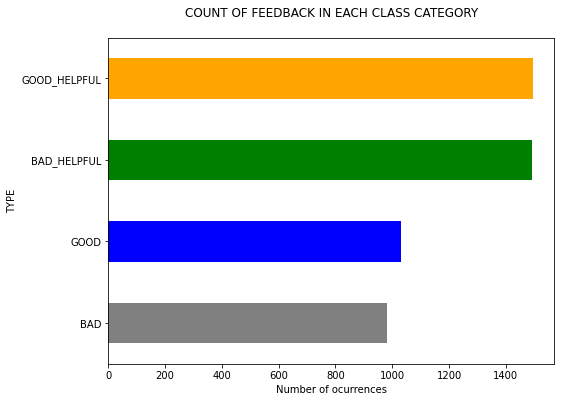

In [ ]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','blue','green','orange']
df2.groupby('TYPE').content.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'COUNT OF FEEDBACK IN EACH CLASS CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

plotting the distribution for the 4 classes

In [ ]:
df2['content'] = df2['content'].astype(str)
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df2.content).toarray()
labels = df2.category_id
features.shape

(5000, 2718)

Each of the 5000 complaints is represented by 2718 features (TF-IDF score of unigrams and bigrams)

In [ ]:
# 3 top  terms with each category id
N = 3
for TYPE, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

  print("\n==> %s:" %(TYPE))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))



==> BAD:
  * Most Correlated Unigrams are: wrong, uninstalled, bad
  * Most Correlated Bigrams are: wrong location, bad direction, wrong direction

==> BAD_HELPFUL:
  * Most Correlated Unigrams are: nan, unusable, useless
  * Most Correlated Bigrams are: calculate route, late update, android auto

==> GOOD:
  * Most Correlated Unigrams are: helpful, love, nan
  * Most Correlated Bigrams are: love police, love use, easy use

==> GOOD_HELPFUL:
  * Most Correlated Unigrams are: police, hazard, nan
  * Most Correlated Bigrams are: real time, object road, speed limit


In [ ]:
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [ ]:
X = df2['content'] 
y = df2['TYPE']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.4656,0.031722
LogisticRegression,0.4966,0.040352
MultinomialNB,0.4494,0.010854
RandomForestClassifier,0.4104,0.006804


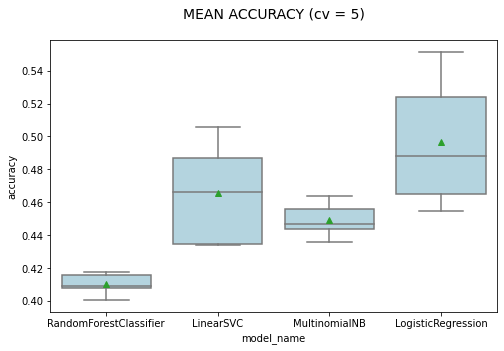

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df2['content'], df['TYPE'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
print(clf.predict(count_vect.transform(["run"]))) #testing

['BAD_HELPFUL']


In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df2.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.TYPE.values, yticklabels=category_id_df.TYPE.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


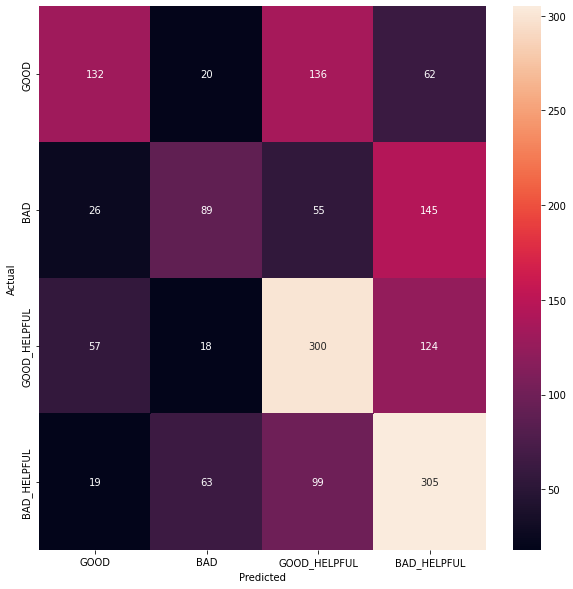

In [ ]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.TYPE.values, yticklabels=category_id_df.TYPE.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

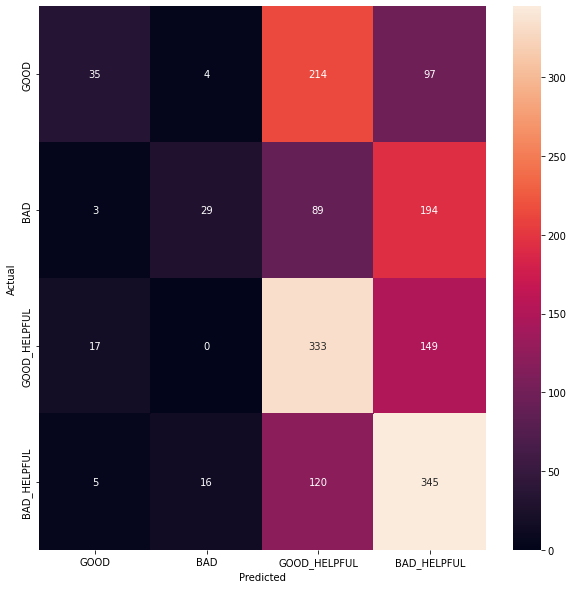

In [ ]:
model = MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.TYPE.values, yticklabels=category_id_df.TYPE.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

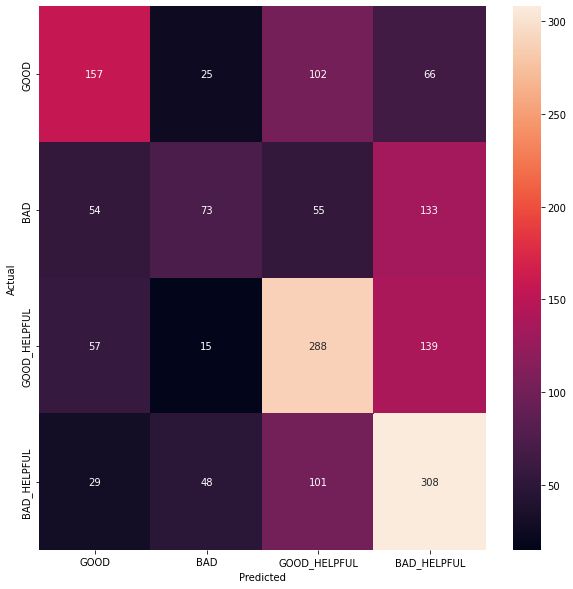

In [ ]:
model = RandomForestClassifier()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.TYPE.values, yticklabels=category_id_df.TYPE.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

all models did a good job predicting the good helpful and bad helpful reviews, however the accuracy was poor for good/bad classes that were non helpful.

In [ ]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['TYPE', 'content']])
      print('')


In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df2['TYPE'].unique()))

              precision    recall  f1-score   support

        GOOD       0.53      0.45      0.49       350
         BAD       0.45      0.23      0.31       315
GOOD_HELPFUL       0.53      0.58      0.55       499
 BAD_HELPFUL       0.48      0.63      0.54       486

    accuracy                           0.50      1650
   macro avg       0.50      0.47      0.47      1650
weighted avg       0.50      0.50      0.49      1650

